# Portfolio Analysis
Investment Analysis with Machine Learning\
UROP 1100E (Man Yin Michael YEUNG, 2021 Fall)

## Monthly and 5d Return Preprocessing

In [1]:
import pandas as pd; import numpy as np
from IPython.display import clear_output

In [2]:
msf = pd.read_csv('C:/UROP/full_version_data/msf.csv') # MSF data provided

In [5]:
dsf = pd.read_parquet('C:/Users/YMYM/Desktop/UROP1100/codes/dsf.parquet.gzip') # DSF data provided

In [3]:
msf.head(3)

,SecuCode,SecuAbbr,date,prc,dvol,Adjfac,ret,AFloats,TotalShares,rvol20d,...,pret20d,pret60d,pret125d,pret250d,float,totcap,indcode,indname,specret,sturn
0,1,平安银行,2000-03-31,18.37,1.319892e+08,20.4319,NaN,1.071634e+09,1.551847e+09,NaN,...,NaN,NaN,NaN,NaN,1.968592e+10,2.850743e+10,SW480000,Banking,NaN,0.006699
1,1,平安银行,2000-04-28,19.05,3.897907e+09,20.4319,0.037017,1.071634e+09,1.551847e+09,0.012733,...,0.037017,NaN,NaN,NaN,2.041464e+10,2.956269e+10,SW480000,Banking,NaN,0.190640
2,1,平安银行,2000-05-31,18.00,1.779608e+09,20.4319,-0.055118,1.071634e+09,1.551847e+09,0.014723,...,-0.059070,NaN,NaN,NaN,1.928942e+10,2.793325e+10,SW480000,Banking,NaN,0.091453


In [4]:
msf['month'] = msf['date'].map(lambda x: x[:7])

In [6]:
dsf= dsf[['SecuCode','date','specret']].dropna().reset_index().drop(columns=['index'])

In [7]:
dsf.date = dsf.date.map(lambda x: x.strftime('%Y-%m-%d'))
date_list = list(dsf.date.unique())
for dt in range(1,6):
    prev_trade_date_dict = dict()
    for index in range(1,len(date_list)):
        print(dt, index); clear_output(wait=True)
        prev_trade_date_dict[date_list[index]] = date_list[index-dt]
    price_data_copy = dsf.copy().loc[dsf.date != date_list[0]]
    price_data_copy.date = price_data_copy.date.map(lambda x: prev_trade_date_dict[x])
    price_data_copy = price_data_copy.rename(columns={'specret':'specret_t+{Dt}'.format(Dt=dt)})
    dsf = pd.merge(dsf, price_data_copy[['SecuCode','date','specret_t+{Dt}'.format(Dt=dt)]],\
                          how = 'inner', on = ['SecuCode','date'])
dsf.head()

,SecuCode,date,specret,specret_t+1,specret_t+2,specret_t+3,specret_t+4,specret_t+5
0,000876,2001-04-16,-0.015848,0.026132,-0.015259,0.004399,-0.025726,-0.012984
1,000425,2001-04-16,-0.001941,0.036524,0.013614,0.009816,0.029656,0.005790
2,600800,2001-04-16,-0.014478,-0.015178,0.003704,0.013818,0.014727,0.045301
3,000831,2001-04-16,-0.009161,-0.011471,0.005515,0.009337,-0.005023,0.002681
4,600694,2001-04-16,0.001786,-0.004309,-0.011374,-0.008585,-0.000338,-0.005862


In [8]:
dsf['specret_tp1-tp5'] = dsf['specret_t+1'] + dsf['specret_t+2'] + dsf['specret_t+3'] + dsf['specret_t+4'] + dsf['specret_t+5']

In [9]:
dsf['SecuCode'] = dsf['SecuCode'].map(int)
msf['SecuCode'] = msf['SecuCode'].map(int)

In [11]:
def get_prev_month(mstr):
    year = mstr[:4]; month = mstr[-2:]
    if int(month) == 1: return str(int(year)-1)+'-12'
    elif int(month) > 10: return str(year)+'-'+str(int(month)-1)
    else: return str(year)+'-0'+str(int(month)-1)
def get_next_month(mstr):
    year = mstr[:4]; month = mstr[-2:]
    if int(month) == 12: return str(int(year)+1)+'-01'
    elif int(month) > 8: return str(year)+'-'+str(int(month)+1)
    else: return str(year)+'-0'+str(int(month)+1)

In [12]:
msf['month'] = msf['month'].map(get_prev_month)

In [13]:
dsf['SecuCode'] = dsf['SecuCode'].map(int)

In [14]:
month_end_dates = list(msf['date'])

In [15]:
dsf = dsf[['SecuCode','date','specret_tp1-tp5']].loc[dsf['date'].isin(month_end_dates)]

In [16]:
dsf['month'] = dsf['date'].map(lambda x: x[:7])

In [17]:
msf = msf[['SecuCode','month','ret']].groupby(['SecuCode','month']).median().join(dsf[['SecuCode','month','specret_tp1-tp5']].groupby(['SecuCode','month']).median(),how='outer').dropna()

In [18]:
msf = msf.reset_index()

In [19]:
msf.head()

,SecuCode,month,ret,specret_tp1-tp5
0,1,2001-04,0.043142,0.003196
1,1,2001-05,-0.054938,-0.031188
2,1,2001-06,-0.096669,0.004967
3,1,2001-07,-0.080983,0.040344
4,1,2001-08,0.003147,0.010343


In [20]:
msf.to_parquet('C:/UROP/full_version_data/monthly_and_5d_ret.parquet.gzip')

## Dictionary-based Scores

In [21]:
dict_scores = pd.read_parquet('C:/UROP/full_version_data/data_dict_scores.parquet.gzip') # partial results

In [22]:
dict_scores = dict_scores.drop(columns=['jieba_content','jieba_sentence'])

In [23]:
dict_scores.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,dict1_words,dict1_sentences,dict2_words,dict2_sentences,...,dict3_score3,dict3_score4,dict3_score5,dict3_score6,dict3_score7,dict3_score8,dict3_score9,dict3_score10,dict3_score11,dict3_score12
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[31, 5, 198]","[18, 2, 39]","[11, 4, 198]","[8, 2, 39]",...,0.020202,0.666667,-0.333333,0.333333,0.153846,-0.051282,0.102564,0.750000,-0.250000,0.500000
1,181900,002024,2010-01-04,-0.004292,-0.022783,-0.047744,"[69, 6, 330]","[26, 2, 47]","[48, 5, 330]","[21, 3, 47]",...,0.151515,0.890625,-0.109375,0.781250,0.510638,-0.085106,0.425532,0.857143,-0.142857,0.714286
2,181901,002092,2010-01-04,0.030815,0.018962,0.055390,"[23, 0, 185]","[16, 0, 29]","[8, 0, 185]","[7, 0, 29]",...,0.086486,1.000000,0.000000,1.000000,0.379310,0.000000,0.379310,1.000000,0.000000,1.000000


In [24]:
def normalize_col(col):
    min_ = col.min(); max_ = col.max()
    return col.map(lambda x: (x-min_)/(max_ - min_))

In [25]:
normalized_cols = []

In [26]:
for dn in [1,2,3]:
    for sn in range(1,13):
        dict_scores['dict{Dn}_score{Sn}_n'.format(Dn=dn,Sn=sn)] = normalize_col(dict_scores['dict{Dn}_score{Sn}'.format(Dn=dn,Sn=sn)])
        normalized_cols.append('dict{Dn}_score{Sn}_n'.format(Dn=dn,Sn=sn))

In [27]:
dict_scores.head(3)

,ID,SecuCode,date,specret,specret_2d,specret_tp2-tp6,dict1_words,dict1_sentences,dict2_words,dict2_sentences,...,dict3_score3_n,dict3_score4_n,dict3_score5_n,dict3_score6_n,dict3_score7_n,dict3_score8_n,dict3_score9_n,dict3_score10_n,dict3_score11_n,dict3_score12_n
0,181899,600323,2010-01-04,0.006658,-0.001522,-0.030300,"[31, 5, 198]","[18, 2, 39]","[11, 4, 198]","[8, 2, 39]",...,0.444203,0.666667,0.666667,0.666667,0.153846,0.948718,0.551282,0.750000,0.750000,0.750000
1,181900,002024,2010-01-04,-0.004292,-0.022783,-0.047744,"[69, 6, 330]","[26, 2, 47]","[48, 5, 330]","[21, 3, 47]",...,0.684812,0.890625,0.890625,0.890625,0.510638,0.914894,0.712766,0.857143,0.857143,0.857143
2,181901,002092,2010-01-04,0.030815,0.018962,0.055390,"[23, 0, 185]","[16, 0, 29]","[8, 0, 185]","[7, 0, 29]",...,0.565658,1.000000,1.000000,1.000000,0.379310,1.000000,0.689655,1.000000,1.000000,1.000000


In [28]:
dict_scores['month'] = dict_scores['date'].map(str).map(lambda x: x[:7])
dict_scores['SecuCode'] = dict_scores['SecuCode'].map(int)

In [30]:
dsm0 = dict_scores[['SecuCode','month',*normalized_cols]]
dsm1 = dict_scores[['SecuCode','month',*normalized_cols]].copy()
dsm1['month'] = dsm1['month'].map(get_next_month)
dsm2 = dsm1.copy()
dsm2['month'] = dsm2['month'].map(get_next_month)

## SESTM Scores

In [33]:
sestm_scores = pd.read_parquet('C:/UROP/full_version_data/data_sestm_scores_simple.parquet.gzip') # partial results

In [50]:
sestm_score_cols = list(sestm_scores.columns[6:])

In [51]:
sestm_scores['month'] = sestm_scores['date'].map(str).map(lambda x: x[:7])
sestm_scores['SecuCode'] = sestm_scores['SecuCode'].map(int)

In [52]:
ssm0 = sestm_scores[['SecuCode','month',*sestm_score_cols]]
ssm1 = sestm_scores[['SecuCode','month',*sestm_score_cols]].copy()
ssm1['month'] = ssm1['month'].map(get_next_month)
ssm2 = ssm1.copy()
ssm2['month'] = ssm2['month'].map(get_next_month)

## Dictionary-based: Correlation to Next Month Return (by 30/60/90-day consensus sentiment)

In [31]:
s30 = msf.groupby(['month','SecuCode']).median().join(dsm0.groupby(['month','SecuCode']).mean(), how='inner').dropna().reset_index()
c30 = pd.DataFrame()
c30['score_name'] = normalized_cols
c30['pearson_1m_ret'] = c30['score_name'].map(lambda x: s30.groupby(['month'])[['ret',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c30['spearman_1m_ret'] = c30['score_name'].map(lambda x: s30.groupby(['month'])[['ret',x]].corr(method='spearman').unstack().iloc[:,1].mean())
c30['pearson_5d_specret'] = c30['score_name'].map(lambda x: s30.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c30['spearman_5d_specret'] = c30['score_name'].map(lambda x: s30.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='spearman').unstack().iloc[:,1].mean())

In [118]:
c30.sort_values(by='spearman_1m_ret', ascending=False).head(3)

,score_name,pearson_1m_ret,spearman_1m_ret,pearson_5d_specret,spearman_5d_specret
14,dict2_score3_n,0.025956,0.029089,0.001267,0.002005
12,dict2_score1_n,0.019099,0.026349,-0.003286,0.002500
20,dict2_score9_n,0.025533,0.026307,0.004056,0.002667


In [119]:
s60 = msf.groupby(['month','SecuCode']).median().join(dsm0.append(dsm1).groupby(['month','SecuCode']).mean(), how='inner').dropna().reset_index()
c60 = pd.DataFrame()
c60['score_name'] = normalized_cols
c60['pearson_1m_ret'] = c60['score_name'].map(lambda x: s60.groupby(['month'])[['ret',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c60['spearman_1m_ret'] = c60['score_name'].map(lambda x: s60.groupby(['month'])[['ret',x]].corr(method='spearman').unstack().iloc[:,1].mean())
c60['pearson_5d_specret'] = c60['score_name'].map(lambda x: s60.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c60['spearman_5d_specret'] = c60['score_name'].map(lambda x: s60.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='spearman').unstack().iloc[:,1].mean())

In [120]:
c60.sort_values(by='spearman_5d_specret', ascending=False).head(3)

,score_name,pearson_1m_ret,spearman_1m_ret,pearson_5d_specret,spearman_5d_specret
24,dict3_score1_n,0.021980,0.028007,0.000010,0.005263
30,dict3_score7_n,0.022495,0.026261,0.003378,0.005175
6,dict1_score7_n,0.024870,0.029340,0.003622,0.005166


In [121]:
s90 = msf.groupby(['month','SecuCode']).median().join(dsm0.append(dsm1).append(dsm2).groupby(['month','SecuCode']).mean(), how='inner').dropna().reset_index()
c90 = pd.DataFrame()
c90['score_name'] = normalized_cols
c90['pearson_1m_ret'] = c30['score_name'].map(lambda x: s90.groupby(['month'])[['ret',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c90['spearman_1m_ret'] = c30['score_name'].map(lambda x: s90.groupby(['month'])[['ret',x]].corr(method='spearman').unstack().iloc[:,1].mean())
c90['pearson_5d_specret'] = c90['score_name'].map(lambda x: s90.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c90['spearman_5d_specret'] = c90['score_name'].map(lambda x: s90.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='spearman').unstack().iloc[:,1].mean())

In [122]:
c90.sort_values(by='spearman_5d_specret', ascending=False).head(3)

,score_name,pearson_1m_ret,spearman_1m_ret,pearson_5d_specret,spearman_5d_specret
30,dict3_score7_n,0.021406,0.025660,0.005217,0.005711
6,dict1_score7_n,0.023617,0.029110,0.005012,0.005472
18,dict2_score7_n,0.022173,0.028967,0.002816,0.005409


## 30/60/90-day Dictionary-based Consensus Sentiment against t+1 Monthly and 5d Return

In [146]:
import seaborn as sns; import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [96]:
normalized_cols_abbr = ['d'+col[4]+'s'+col[11:13] for col in normalized_cols]

In [98]:
sdf = s30.copy()

In [104]:
months = list(sdf['month'].unique())

In [105]:
rrss_mat = []
for score_this in normalized_cols:
    rrss = []
    for partition_num in [-1]+(list(range(1,11))):
        print(score_this,partition_num); clear_output(wait=True)
        prets = []; acc_val = [1]
        for month_this in months:    
            sdfi = sdf.loc[sdf.month == month_this].sort_values(by=score_this,ascending=False)
            if not len(sdfi): continue
            if partition_num == -1:
                prets.append(sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean()))
            else:
                prets.append(sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean()))
        rrs = [round(np.array(prets).mean()*12,4), round(np.array(prets).std()*(12**0.5),4),round((np.array(prets).mean()*12)/(np.array(prets).std()*(12**0.5)),4), acc_val]
        rrss.extend(rrs)
    rrss_mat.append(rrss)

dict3_score12_n 10


In [106]:
ind = []
for i in range(0,11):
    ind += ['Annual Return '+str(i),'Annual Risk '+str(i),'Sharpe '+str(i),'Acc Val '+str(i)]
rrssdf_30 = pd.DataFrame(np.array(rrss_mat).T,columns=normalized_cols_abbr)
rrssdf_30['ind'] = ind; rrssdf_30.index = rrssdf_30.ind; rrssdf_30 = rrssdf_30.drop(columns=['ind'])

c:\users\ymym\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [115]:
rrssdf_30.to_csv('rrss30_df.csv')

In [123]:
sdf = s60.copy()

In [124]:
rrss_mat = []
for score_this in normalized_cols:
    rrss = []
    for partition_num in [-1]+(list(range(1,11))):
        print(score_this,partition_num); clear_output(wait=True)
        prets = []; acc_val = [1]
        for month_this in months:    
            sdfi = sdf.loc[sdf.month == month_this].sort_values(by=score_this,ascending=False)
            if not len(sdfi): continue
            if partition_num == -1:
                prets.append(sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean()))
            else:
                prets.append(sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean()))
        rrs = [round(np.array(prets).mean()*12,4), round(np.array(prets).std()*(12**0.5),4),round((np.array(prets).mean()*12)/(np.array(prets).std()*(12**0.5)),4), acc_val]
        rrss.extend(rrs)
    rrss_mat.append(rrss)

dict3_score12_n 10


In [125]:
ind = []
for i in range(0,11):
    ind += ['Annual Return '+str(i),'Annual Risk '+str(i),'Sharpe '+str(i), 'Acc Val '+str(i)]
rrssdf_60 = pd.DataFrame(np.array(rrss_mat).T,columns=normalized_cols_abbr)
rrssdf_60['ind'] = ind; rrssdf_60.index = rrssdf_60.ind; rrssdf_60 = rrssdf_60.drop(columns=['ind'])

c:\users\ymym\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [127]:
rrssdf_60.to_csv('rrss60_df.csv')

In [128]:
sdf = s90.copy()

In [129]:
rrss_mat = []
for score_this in normalized_cols:
    rrss = []
    for partition_num in [-1]+(list(range(1,11))):
        print(score_this,partition_num); clear_output(wait=True)
        prets = []; acc_val = [1]
        for month_this in months:    
            sdfi = sdf.loc[sdf.month == month_this].sort_values(by=score_this,ascending=False)
            if not len(sdfi): continue
            if partition_num == -1:
                prets.append(sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean()))
            else:
                prets.append(sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean()))
        rrs = [round(np.array(prets).mean()*12,4), round(np.array(prets).std()*(12**0.5),4),round((np.array(prets).mean()*12)/(np.array(prets).std()*(12**0.5)),4), acc_val]
        rrss.extend(rrs)
    rrss_mat.append(rrss)

dict3_score12_n 10


In [130]:
ind = []
for i in range(0,11):
    ind += ['Annual Return '+str(i),'Annual Risk '+str(i),'Sharpe '+str(i), 'Acc Val '+str(i)]
rrssdf_90 = pd.DataFrame(np.array(rrss_mat).T,columns=normalized_cols_abbr)
rrssdf_90['ind'] = ind; rrssdf_90.index = rrssdf_90.ind; rrssdf_90 = rrssdf_90.drop(columns=['ind'])

c:\users\ymym\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [131]:
rrssdf_90.to_csv('rrss90_df.csv')

In [441]:
rrssdf_30 = pd.read_csv('rrss30_df.csv')
rrssdf_60 = pd.read_csv('rrss60_df.csv')
rrssdf_90 = pd.read_csv('rrss90_df.csv')

In [442]:
rrssdf_30 = rrssdf_30.reset_index()
rrssdf_30['stat'] = rrssdf_30['ind'].map(lambda x: x[:-2]).map(lambda x: x.strip())
rrssdf_30['portfolio'] = rrssdf_30['ind'].map(lambda x: x[-2:]).map(int)
rrssdf_30['dur'] = 30
rrssdf_30 = rrssdf_30.drop(columns=['index'])

In [443]:
rrssdf_60 = rrssdf_60.reset_index()
rrssdf_60['stat'] = rrssdf_60['ind'].map(lambda x: x[:-2]).map(lambda x: x.strip())
rrssdf_60['portfolio'] = rrssdf_60['ind'].map(lambda x: x[-2:]).map(int)
rrssdf_60['dur'] = 60
rrssdf_60 = rrssdf_60.drop(columns=['index'])

In [444]:
rrssdf_90 = rrssdf_90.reset_index()
rrssdf_90['stat'] = rrssdf_90['ind'].map(lambda x: x[:-2]).map(lambda x: x.strip())
rrssdf_90['portfolio'] = rrssdf_90['ind'].map(lambda x: x[-2:]).map(int)
rrssdf_90['dur'] = 90
rrssdf_90 = rrssdf_90.drop(columns=['index'])

In [445]:
rrssdf_all = rrssdf_30.append(rrssdf_60).append(rrssdf_90)[['dur','portfolio','stat',*normalized_cols_abbr]]

In [446]:
rrssdf_all.to_csv('rrss-all_df.csv')

In [447]:
rrssdf_all.head()

,dur,portfolio,stat,d1s1_,d1s2_,d1s3_,d1s4_,d1s5_,d1s6_,d1s7_,...,d3s3_,d3s4_,d3s5_,d3s6_,d3s7_,d3s8_,d3s9_,d3s10,d3s11,d3s12
0,30,0,Annual Return,0.0485,0.0643,0.0765,0.0818,0.0818,0.0818,0.0637,...,0.066,0.0681,0.0681,0.0681,0.0375,0.0686,0.0671,0.072,0.0718,0.0721
1,30,0,Annual Risk,0.0796,0.1134,0.1065,0.1196,0.1196,0.1196,0.0943,...,0.1026,0.1105,0.1105,0.1105,0.0924,0.1036,0.1081,0.1067,0.1067,0.1068
2,30,0,Sharpe,0.6096,0.5674,0.7185,0.6843,0.6837,0.6837,0.6756,...,0.6435,0.6163,0.6163,0.6161,0.4061,0.6626,0.6212,0.6745,0.6731,0.6756
3,30,0,Acc Val,"[1, 0.9895345821909484, 0.9884626326485948, 1....","[1, 1.0126598850010335, 1.0234751906418178, 1....","[1, 1.0026064331785434, 1.012484624312181, 1.0...","[1, 1.0073394739719363, 1.0145902238361164, 1....","[1, 1.0073394739719363, 1.0145902238361164, 1....","[1, 1.0073394739719363, 1.0145902238361164, 1....","[1, 0.9981132379847455, 0.9973721746322253, 1....",...,"[1, 1.005580531241339, 1.0149710221745367, 1.0...","[1, 1.0021907144297397, 1.0046777665065623, 1....","[1, 1.0021907144297397, 1.0046777665065623, 1....","[1, 1.0021907144297397, 1.0046777665065623, 1....","[1, 1.0044116852280824, 1.023503027313782, 1.0...","[1, 1.0006849547281063, 1.0009776175377272, 1....","[1, 1.000722967728121, 1.0172765397534735, 1.0...","[1, 1.0011683020703974, 1.0166236447439694, 1....","[1, 1.0011683020703974, 1.0166236447439694, 1....","[1, 1.0011683020703974, 1.0166236447439694, 1...."
4,30,1,Annual Return,0.1893,0.2061,0.2083,0.1977,0.1978,0.1982,0.2002,...,0.206,0.1977,0.1977,0.1969,0.1922,0.1975,0.2051,0.2004,0.2003,0.2009


## SESTM: Correlation to Next Month Return (by 30/60/90-day consensus sentiment)

In [234]:
s30 = msf.groupby(['month','SecuCode']).median().join(ssm0.groupby(['month','SecuCode']).mean(), how='inner').dropna().reset_index()
c30 = pd.DataFrame()
c30['score_name'] = sestm_score_cols
c30['pearson_1m_ret'] = c30['score_name'].map(lambda x: s30.groupby(['month'])[['ret',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c30['spearman_1m_ret'] = c30['score_name'].map(lambda x: s30.groupby(['month'])[['ret',x]].corr(method='spearman').unstack().iloc[:,1].mean())
c30['pearson_5d_specret'] = c30['score_name'].map(lambda x: s30.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c30['spearman_5d_specret'] = c30['score_name'].map(lambda x: s30.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='spearman').unstack().iloc[:,1].mean())

In [235]:
c30.sort_values(by='spearman_1m_ret', ascending=False).head(3)

,score_name,pearson_1m_ret,spearman_1m_ret,pearson_5d_specret,spearman_5d_specret
7,sestm_0.97_50_0.1_av_specret_2d_TDR=True_93151,0.012332,0.010970,0.012246,0.008803
5,sestm_0.97_50_0.1_av_specret_2d_TDR=False_93151,0.014959,0.009908,0.014416,0.010181
6,sestm_0.97_50_0.1_len-wise_specret_2d_TDR=True...,0.004575,0.005310,0.005868,0.009699


In [236]:
s60 = msf.groupby(['month','SecuCode']).median().join(dsm0.append(ssm1).groupby(['month','SecuCode']).mean(), how='inner').dropna().reset_index()
c60 = pd.DataFrame()
c60['score_name'] = sestm_score_cols
c60['pearson_1m_ret'] = c60['score_name'].map(lambda x: s60.groupby(['month'])[['ret',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c60['spearman_1m_ret'] = c60['score_name'].map(lambda x: s60.groupby(['month'])[['ret',x]].corr(method='spearman').unstack().iloc[:,1].mean())
c60['pearson_5d_specret'] = c60['score_name'].map(lambda x: s60.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c60['spearman_5d_specret'] = c60['score_name'].map(lambda x: s60.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='spearman').unstack().iloc[:,1].mean())

In [237]:
c60.sort_values(by='spearman_5d_specret', ascending=False).head(3)

,score_name,pearson_1m_ret,spearman_1m_ret,pearson_5d_specret,spearman_5d_specret
5,sestm_0.97_50_0.1_av_specret_2d_TDR=False_93151,0.018625,0.017600,0.015687,0.010746
4,sestm_0.97_50_0.1_len-wise_specret_2d_TDR=Fals...,0.008670,0.006453,0.012468,0.010292
1,sestm_0.97_500_0.1_av_specret_2d_TDR=False_78786,0.004717,-0.000028,0.014732,0.008964


In [238]:
s90 = msf.groupby(['month','SecuCode']).median().join(dsm0.append(dsm1).append(ssm2).groupby(['month','SecuCode']).mean(), how='inner').dropna().reset_index()
c90 = pd.DataFrame()
c90['score_name'] = sestm_score_cols
c90['pearson_1m_ret'] = c30['score_name'].map(lambda x: s90.groupby(['month'])[['ret',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c90['spearman_1m_ret'] = c30['score_name'].map(lambda x: s90.groupby(['month'])[['ret',x]].corr(method='spearman').unstack().iloc[:,1].mean())
c90['pearson_5d_specret'] = c90['score_name'].map(lambda x: s90.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='pearson').unstack().iloc[:,1].mean())
c90['spearman_5d_specret'] = c90['score_name'].map(lambda x: s90.groupby(['month'])[['specret_tp1-tp5',x]].corr(method='spearman').unstack().iloc[:,1].mean())

In [239]:
c90.sort_values(by='spearman_5d_specret', ascending=False).head(3)

,score_name,pearson_1m_ret,spearman_1m_ret,pearson_5d_specret,spearman_5d_specret
3,sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786,0.007074,0.002138,0.006934,-0.000804
2,sestm_0.97_500_0.1_len-wise_specret_2d_TDR=Tru...,0.002256,-0.001910,0.003952,-0.002243
7,sestm_0.97_50_0.1_av_specret_2d_TDR=True_93151,0.014041,0.012368,0.004208,-0.002904


## 30/60/90-day SESTM Consensus Sentiment against t+1 Monthly and 5d Return

In [240]:
sdf = s30.copy()

In [241]:
months = list(sdf['month'].unique())

In [242]:
rrss_mat = []
for score_this in sestm_score_cols:
    rrss = []
    for partition_num in [-1]+(list(range(1,11))):
        print(score_this,partition_num); clear_output(wait=True)
        prets = []; acc_val = [1]
        for month_this in months:    
            sdfi = sdf.loc[sdf.month == month_this].sort_values(by=score_this,ascending=False)
            if not len(sdfi): continue
            if partition_num == -1:
                prets.append(sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean()))
            else:
                prets.append(sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean()))
        rrs = [round(np.array(prets).mean()*12,4), round(np.array(prets).std()*(12**0.5),4),round((np.array(prets).mean()*12)/(np.array(prets).std()*(12**0.5)),4), acc_val]
        rrss.extend(rrs)
    rrss_mat.append(rrss)

sestm_0.97_50_0.1_av_specret_2d_TDR=True_93151 10


In [244]:
ind = []
for i in range(0,11):
    ind += ['Annual Return '+str(i),'Annual Risk '+str(i),'Sharpe '+str(i),'Acc Val '+str(i)]
rrssdf_30 = pd.DataFrame(np.array(rrss_mat).T,columns=sestm_score_cols)
rrssdf_30['ind'] = ind; rrssdf_30.index = rrssdf_30.ind; rrssdf_30 = rrssdf_30.drop(columns=['ind'])

c:\users\ymym\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [246]:
rrssdf_30.to_csv('rrss30_df_sestm.csv')

In [247]:
sdf = s60.copy()

In [248]:
rrss_mat = []
for score_this in sestm_score_cols:
    rrss = []
    for partition_num in [-1]+(list(range(1,11))):
        print(score_this,partition_num); clear_output(wait=True)
        prets = []; acc_val = [1]
        for month_this in months:    
            sdfi = sdf.loc[sdf.month == month_this].sort_values(by=score_this,ascending=False)
            if not len(sdfi): continue
            if partition_num == -1:
                prets.append(sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean()))
            else:
                prets.append(sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean()))
        rrs = [round(np.array(prets).mean()*12,4), round(np.array(prets).std()*(12**0.5),4),round((np.array(prets).mean()*12)/(np.array(prets).std()*(12**0.5)),4), acc_val]
        rrss.extend(rrs)
    rrss_mat.append(rrss)

sestm_0.97_50_0.1_av_specret_2d_TDR=True_93151 10


In [249]:
ind = []
for i in range(0,11):
    ind += ['Annual Return '+str(i),'Annual Risk '+str(i),'Sharpe '+str(i), 'Acc Val '+str(i)]
rrssdf_60 = pd.DataFrame(np.array(rrss_mat).T,columns=sestm_score_cols)
rrssdf_60['ind'] = ind; rrssdf_60.index = rrssdf_60.ind; rrssdf_60 = rrssdf_60.drop(columns=['ind'])

c:\users\ymym\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [251]:
rrssdf_60.to_csv('rrss60_df_sestm.csv')

In [252]:
sdf = s90.copy()

In [253]:
rrss_mat = []
for score_this in sestm_score_cols:
    rrss = []
    for partition_num in [-1]+(list(range(1,11))):
        print(score_this,partition_num); clear_output(wait=True)
        prets = []; acc_val = [1]
        for month_this in months:    
            sdfi = sdf.loc[sdf.month == month_this].sort_values(by=score_this,ascending=False)
            if not len(sdfi): continue
            if partition_num == -1:
                prets.append(sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[:int(len(sdfi)/10)*partition_num]['ret'].mean()\
                - sdfi[int(len(sdfi)/10)*(9):]['ret'].mean()))
            else:
                prets.append(sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean())
                acc_val.append(acc_val[-1] * (1+sdfi[int(len(sdfi)/10)*(partition_num-1):int(len(sdfi)/10)*partition_num]['ret'].mean()))
        rrs = [round(np.array(prets).mean()*12,4), round(np.array(prets).std()*(12**0.5),4),round((np.array(prets).mean()*12)/(np.array(prets).std()*(12**0.5)),4), acc_val]
        rrss.extend(rrs)
    rrss_mat.append(rrss)

sestm_0.97_50_0.1_av_specret_2d_TDR=True_93151 10


In [254]:
ind = []
for i in range(0,11):
    ind += ['Annual Return '+str(i),'Annual Risk '+str(i),'Sharpe '+str(i), 'Acc Val '+str(i)]
rrssdf_90 = pd.DataFrame(np.array(rrss_mat).T,columns=sestm_score_cols)
rrssdf_90['ind'] = ind; rrssdf_90.index = rrssdf_90.ind; rrssdf_90 = rrssdf_90.drop(columns=['ind'])

c:\users\ymym\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [255]:
rrssdf_90.to_csv('rrss90_df_sestm.csv')

In [448]:
rrssdf_30 = pd.read_csv('rrss30_df_sestm.csv')
rrssdf_60 = pd.read_csv('rrss60_df_sestm.csv')
rrssdf_90 = pd.read_csv('rrss90_df_sestm.csv')

In [449]:
rrssdf_30 = rrssdf_30.reset_index()
rrssdf_30['stat'] = rrssdf_30['ind'].map(lambda x: x[:-2]).map(lambda x: x.strip())
rrssdf_30['portfolio'] = rrssdf_30['ind'].map(lambda x: x[-2:]).map(int)
rrssdf_30['dur'] = 30
rrssdf_30 = rrssdf_30.drop(columns=['index'])

In [450]:
rrssdf_60 = rrssdf_60.reset_index()
rrssdf_60['stat'] = rrssdf_60['ind'].map(lambda x: x[:-2]).map(lambda x: x.strip())
rrssdf_60['portfolio'] = rrssdf_60['ind'].map(lambda x: x[-2:]).map(int)
rrssdf_60['dur'] = 60
rrssdf_60 = rrssdf_60.drop(columns=['index'])

In [451]:
rrssdf_90 = rrssdf_90.reset_index()
rrssdf_90['stat'] = rrssdf_90['ind'].map(lambda x: x[:-2]).map(lambda x: x.strip())
rrssdf_90['portfolio'] = rrssdf_90['ind'].map(lambda x: x[-2:]).map(int)
rrssdf_90['dur'] = 90
rrssdf_90 = rrssdf_90.drop(columns=['index'])

In [452]:
rrssdf_all = rrssdf_30.append(rrssdf_60).append(rrssdf_90)[['dur','portfolio','stat',*sestm_score_cols]]

In [453]:
rrssdf_all.to_csv('rrss-all_df_sestm.csv')

In [454]:
rrssdf_all.head(4)

,dur,portfolio,stat,sestm_0.97_500_0.1_len-wise_specret_2d_TDR=False_9284,sestm_0.97_500_0.1_av_specret_2d_TDR=False_78786,sestm_0.97_500_0.1_len-wise_specret_2d_TDR=True_9284,sestm_0.97_500_0.1_av_specret_2d_TDR=True_78786,sestm_0.97_50_0.1_len-wise_specret_2d_TDR=False_5024,sestm_0.97_50_0.1_av_specret_2d_TDR=False_93151,sestm_0.97_50_0.1_len-wise_specret_2d_TDR=True_5024,sestm_0.97_50_0.1_av_specret_2d_TDR=True_93151
0,30,0,Annual Return,0.0594,0.0592,0.0684,0.0616,0.0792,0.0857,0.0555,0.0731
1,30,0,Annual Risk,0.1215,0.1216,0.1161,0.1145,0.0851,0.0886,0.084,0.0864
2,30,0,Sharpe,0.4892,0.4866,0.5894,0.5385,0.9308,0.9672,0.6606,0.8456
3,30,0,Acc Val,"[1, 1.0461160769790532, 1.0482579432292312, 1....","[1, 1.0593668042276547, 1.0650971128105446, 1....","[1, 1.046209404693553, 1.0405394934586043, 1.0...","[1, 1.053599410210428, 1.0560664379595346, 1.0...","[1, 1.0200934563693538, 1.0422220286468402, 1....","[1, 1.0250360712461453, 1.033256645233008, 1.0...","[1, 1.0244723546837275, 1.0379176235777092, 1....","[1, 1.0192081118214174, 1.0408759117334854, 1...."


# Visualize All Results

In [27]:
import pandas as pd; import numpy as np; from IPython.display import clear_output
from seaborn import heatmap; import matplotlib.pyplot as plt; from matplotlib.gridspec import GridSpec

In [28]:
# read CSVs
hmdf_c1 = pd.read_csv('rrss-all_df.csv', index_col = 0)
hmdf_c2 = pd.read_csv('rrss-all_df_sestm.csv', index_col = 0)

In [29]:
# Column Options
print('** DICT COLUMNS: (full data)'); print(*list(pd.read_csv('rrss-all_df.csv', index_col = 0).columns)[3:])
print('** SESTM COLUMNS: (test data)'); temp = pd.read_csv('rrss-all_df_sestm.csv', index_col = 0)
print(*list(temp.columns[3:].map(lambda x: x[6:])))

** DICT COLUMNS: (full data)
d1s1_ d1s2_ d1s3_ d1s4_ d1s5_ d1s6_ d1s7_ d1s8_ d1s9_ d1s10 d1s11 d1s12 d2s1_ d2s2_ d2s3_ d2s4_ d2s5_ d2s6_ d2s7_ d2s8_ d2s9_ d2s10 d2s11 d2s12 d3s1_ d3s2_ d3s3_ d3s4_ d3s5_ d3s6_ d3s7_ d3s8_ d3s9_ d3s10 d3s11 d3s12
** SESTM COLUMNS: (test data)
0.97_500_0.1_len-wise_specret_2d_TDR=False_9284 0.97_500_0.1_av_specret_2d_TDR=False_78786 0.97_500_0.1_len-wise_specret_2d_TDR=True_9284 0.97_500_0.1_av_specret_2d_TDR=True_78786 0.97_50_0.1_len-wise_specret_2d_TDR=False_5024 0.97_50_0.1_av_specret_2d_TDR=False_93151 0.97_50_0.1_len-wise_specret_2d_TDR=True_5024 0.97_50_0.1_av_specret_2d_TDR=True_93151


### Specifications (Plot 1)

In [22]:
# choose some column(s) from those printed above (DICT or SESTM COLUMNS) WITH PREFIX '30d_', '60_' or '90d_'
# NOTE1: DICT tags are stuctured: (<signal_length>)_d<dict_num>s<score_num_in_2_digits(may contain underscore as suffix, e.g. 6 --> '6_', 10 --> '10')>
# NOTE2: SESTM tags are structured: (<signal_length>_)_<kappa_quantile>_<num_words>_<lambda>_<pos_filter>_<train_label>_<train_data_filter>_<words_hash_sum>

portfolio_used = 0

model_used = 'sestm'
lines_filter = ['30d_0.97_500_0.1_av_specret_2d_TDR=True_78786','60d_0.97_500_0.1_av_specret_2d_TDR=True_78786','90d_0.97_500_0.1_av_specret_2d_TDR=True_78786']

# SAMPLES

#model_used = 'dict'
#lines_filter = ['30d_d1s6_','60d_d1s6_','90d_d1s6_']

#model_used = 'sestm'
#lines_filter = ['30d_0.97_500_0.1_av_specret_2d_TDR=True_78786','60d_0.97_500_0.1_av_specret_2d_TDR=True_78786','90d_0.97_500_0.1_av_specret_2d_TDR=True_78786']

### Plotting (Plot 1)

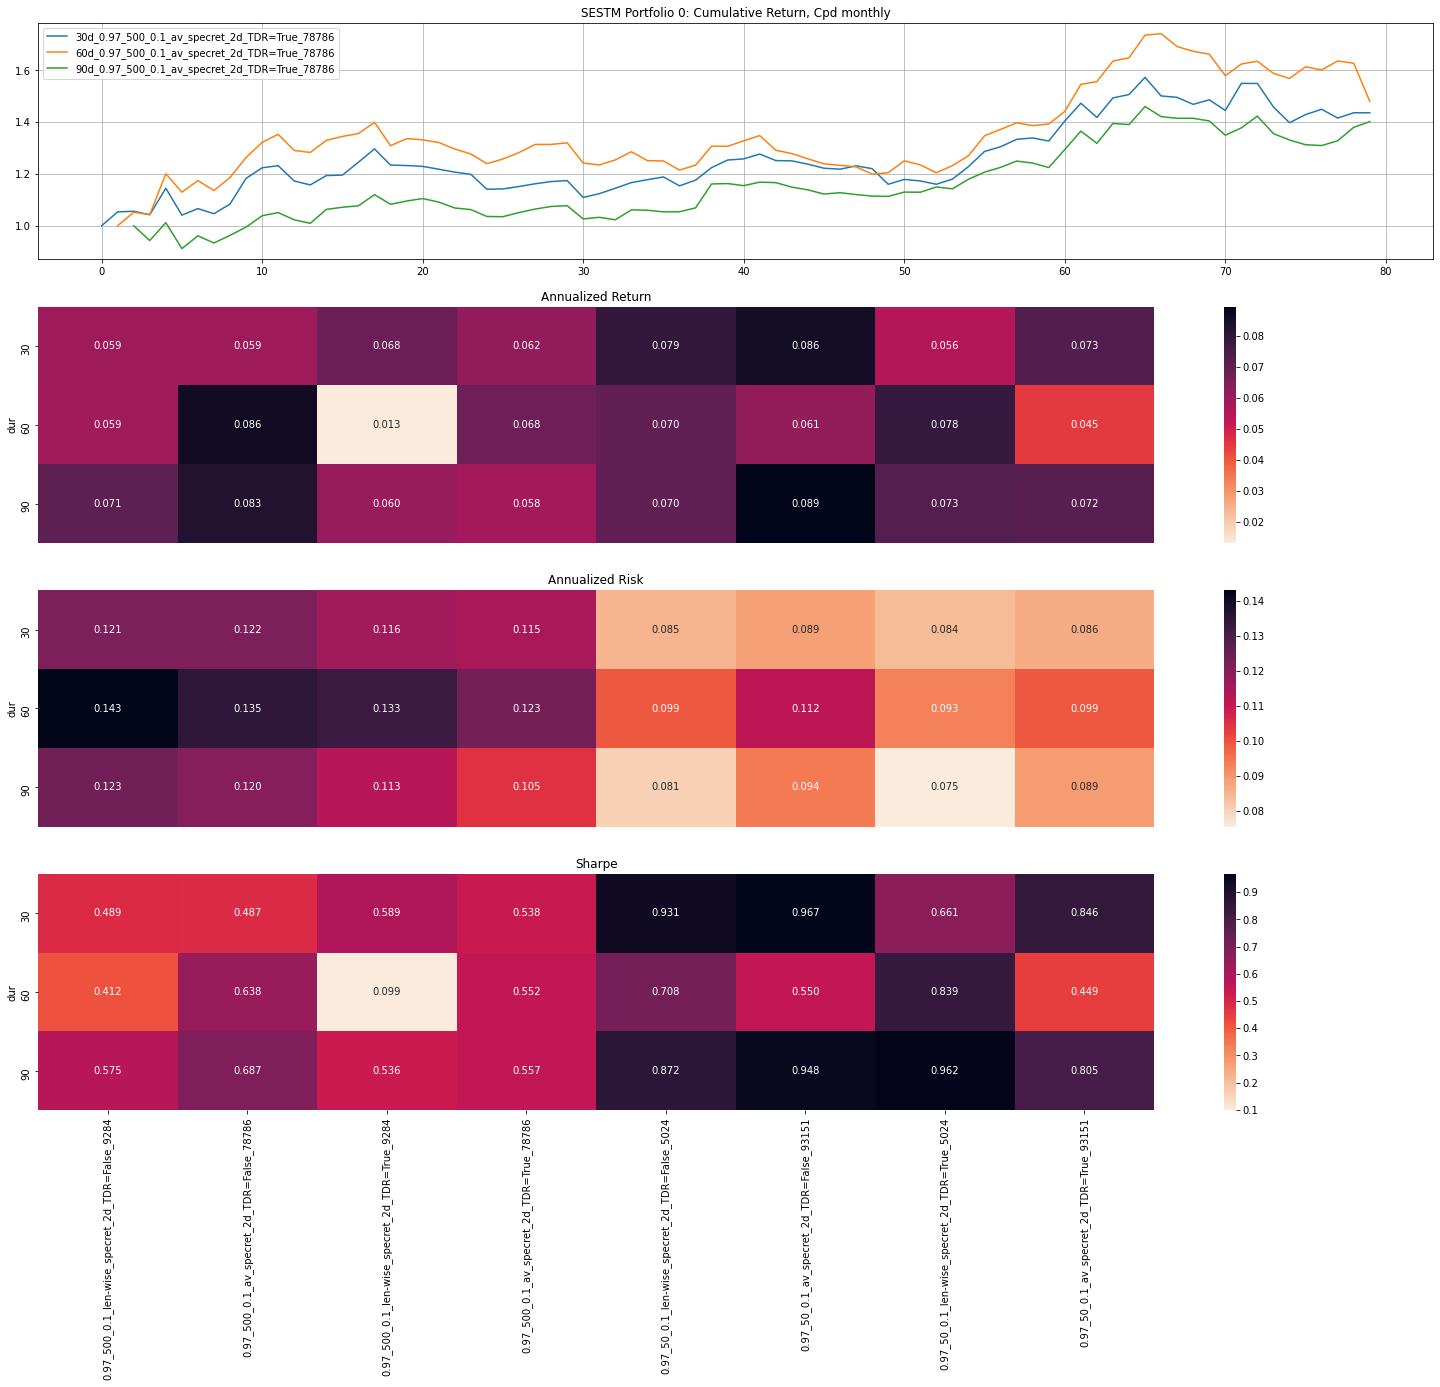

In [23]:
if model_used == 'dict':
    hmdf = hmdf_c1.copy()
elif model_used == 'sestm':
    hmdf = hmdf_c2.copy()
    hmdf.columns = list(hmdf.columns[:3]) + list(hmdf.columns[3:].map(lambda x: x[6:]))
cols_abbr = list(hmdf.columns[3:])
line_df = hmdf.loc[(hmdf.portfolio==portfolio_used) & (hmdf.stat == 'Acc Val')]
plot_lines = dict()
for index, row in line_df.iterrows():
    for col in cols_abbr:
        plot_lines[str(row['dur'])+'d_'+str(col)] = row[col]
hmdf1 = hmdf.loc[(hmdf.portfolio==portfolio_used) & (hmdf.stat == 'Annual Return')]
hmdf2 = hmdf.loc[(hmdf.portfolio==portfolio_used) & (hmdf.stat == 'Annual Risk')]
hmdf3 = hmdf.loc[(hmdf.portfolio==portfolio_used) & (hmdf.stat == 'Sharpe')]
hmdf1.index = hmdf1['dur']; hmdf2.index = hmdf2['dur']; hmdf3.index = hmdf3['dur']
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(25,20))
for k,v in plot_lines.items():
    if k in lines_filter:
        v = eval(v)
        if model_used == 'sestm':
            if k[:2] == '60': v = [None] + v
            if k[:2] == '90': v = [None, None] + v
        pd.Series(v).plot(ax=ax1, label = k)
g2 = heatmap(pd.DataFrame(hmdf1[cols_abbr], dtype="float"), annot=True, fmt='.3f', cmap='rocket_r',ax=ax2); g2.set_title('Annualized Return')
g3 = heatmap(pd.DataFrame(hmdf2[cols_abbr], dtype="float"), annot=True, fmt='.3f', cmap='rocket_r',ax=ax3); g3.set_title('Annualized Risk')
g4 = heatmap(pd.DataFrame(hmdf3[cols_abbr], dtype="float"), annot=True, fmt='.3f', cmap='rocket_r',ax=ax4); g4.set_title('Sharpe')
if model_used == 'sestm': ax2.set_xticks([]); ax3.set_xticks([])
ax1.grid(); ax1.set_title(model_used.upper() + ' Portfolio {Pu}: Cumulative Return, Cpd monthly'.format(Pu=portfolio_used)); ax1.legend(loc='upper left')
plt.savefig('C:/UROP/full_version_data/img/{Mu}_port{Pu}_filter-{Fu}.png'.format(Mu=model_used,Pu=portfolio_used,Fu=str(lines_filter))); plt.show()

### Specification (Plot 2)

In [24]:
# similar to specs of plot 1, but a single entry in lines_filter is recommended (is expected)

model_used = 'dict'
lines_filter = ['30d_d1s6_'] # one only

# SAMPLES

#model_used = 'dict'
#lines_filter = ['30d_d1s6_']

#model_used = 'sestm'
#lines_filter = ['30d_0.97_500_0.1_av_specret_2d_TDR=True_78786']

### Plotting (Plot 2)

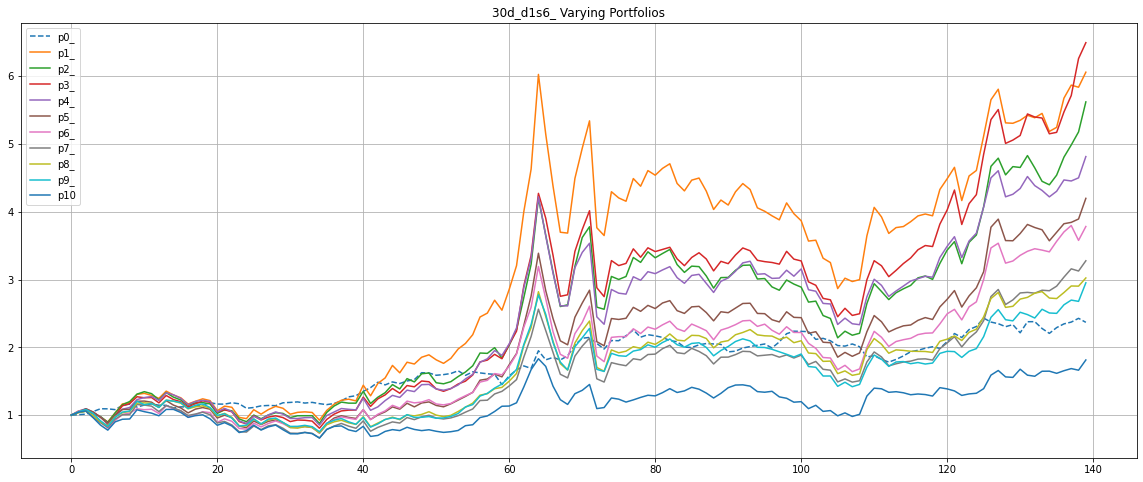

In [26]:
if model_used == 'dict':
    hmdf = hmdf_c1.copy()
elif model_used == 'sestm':
    hmdf = hmdf_c2.copy()
    hmdf.columns = list(hmdf.columns[:3]) + list(hmdf.columns[3:].map(lambda x: x[6:]))
cols_abbr = list(hmdf.columns[3:])
line_df = hmdf.loc[hmdf.stat == 'Acc Val']
plot_lines = dict()
for index, row in line_df.iterrows():
    for col in cols_abbr:
        plot_lines['p'+str(row['portfolio'])+'_'+str(row['dur'])+'d_'+str(col)] = row[col]
plt.figure(figsize=(20,8))
for k,v in plot_lines.items():
    if (k[3:] in lines_filter) or (k[4:] in lines_filter):
        v = eval(v)
        if model_used == 'sestm':
            if k[:2] == '60': v = [None] + v
            if k[:2] == '90': v = [None, None] + v
        if k[1] != '0':
            pd.Series(v).plot(linestyle='-',label = k[:3])
        else:
            pd.Series(v).plot(linestyle='--',label = k[:3])  
            plt.title(str(k[3:])+' Varying Portfolios')
plt.legend(loc='upper left'); plt.grid(); plt.show()